# Packages Imports

In [1]:
import os
import random
from itertools import product

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.metrics import MeanIoU, IoU, CategoricalAccuracy
from keras.models import Model, load_model


from google.colab import drive
drive.mount('/content/drive')
tf.__version__

Mounted at /content/drive


'2.15.0'

# Datasets Loading

The code sets up a deep learning dataset for image classification using TensorFlow, defining parameters like image dimensions, channel count, and classes. It loads the dataset, performs a train-validation split, creates batches, visualizes a subset, and applies a preprocessing function to both training and validation datasets, demonstrating the preparation and exploration steps for image classification.

In [2]:
SIZE = (256, 256)
IMG_CHANNELS = 3
N_CLASSES = 2
BATCH_SIZE = 8
input_shape = (*SIZE, IMG_CHANNELS)

TEST_PATH = '/content/drive/MyDrive/CoMoFoD/test'
TRAIN_PATH = '/content/drive/MyDrive/CoMoFoD/train'
SEED = 42

In [3]:
def load_dataset(PATH, images_folder, masks_folder):
    # Load images
    dataset_images = tf.keras.preprocessing.image_dataset_from_directory(
        f"{PATH}/{images_folder}/",
        label_mode=None,  # Use 'label_mode="int"' if you have categorical labels
        image_size=SIZE,  # Resize images to this size (width, height)
        batch_size=BATCH_SIZE,  # Number of images to include in each batch
        shuffle=False,  # Important to maintain corresponding order with masks

    )

    # Load masks
    dataset_masks = tf.keras.preprocessing.image_dataset_from_directory(
        f"{PATH}/{masks_folder}/",
        label_mode=None,
        image_size=SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,  # Important to maintain corresponding order with images
    )

    dataset = tf.data.Dataset.zip((dataset_images, dataset_masks))
    return dataset

In [4]:
# load the dataset
dataset = load_dataset(TRAIN_PATH, "image", "mask").unbatch()
dataset_aug = load_dataset(TRAIN_PATH, "image_aug", "mask_aug").unbatch()

dataset = dataset.concatenate(dataset_aug).shuffle(buffer_size=500)


# Determine the total size of the dataset
dataset_size = sum(1 for _ in dataset)

# Define your split ratio (e.g., 90% for training, 10% for validation)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
dataset_train = dataset.take(train_size).batch(BATCH_SIZE)
dataset_val = dataset.skip(train_size).batch(BATCH_SIZE)

# load the test dataset
dataset_test = load_dataset(TEST_PATH, "image", "mask")

Found 150 files belonging to 1 classes.
Found 150 files belonging to 1 classes.
Found 750 files belonging to 1 classes.
Found 750 files belonging to 1 classes.
Found 50 files belonging to 1 classes.
Found 50 files belonging to 1 classes.


In [5]:
def preprocess(image, mask, threshold=230):
    # Convert RGB to grayscale by taking the mean across the color channels
    grayscale_mask = tf.reduce_mean(mask, axis=-1)

    # Convert grayscale to binary
    binary_mask = tf.where(grayscale_mask > threshold, 1, 0)

    image = tf.cast(image, tf.float32) / 255.0

    return image, binary_mask

dataset_train = dataset_train.map(preprocess)
dataset_val = dataset_val.map(preprocess)
dataset_test = dataset_test.map(preprocess)

In [6]:
for features, labels in dataset_test.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3)
Labels Batch shape: (8, 256, 256)
Feature shape per sample: (256, 256, 3)
Max Value in Feature: 1.0
Label shape per sample: (256, 256)
Label unique values: [0 1]


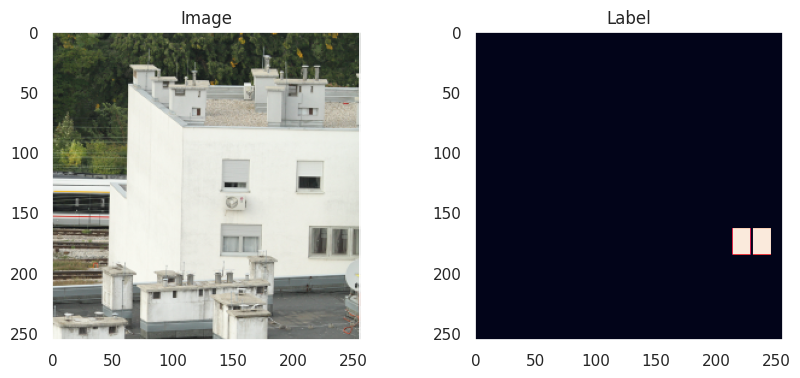

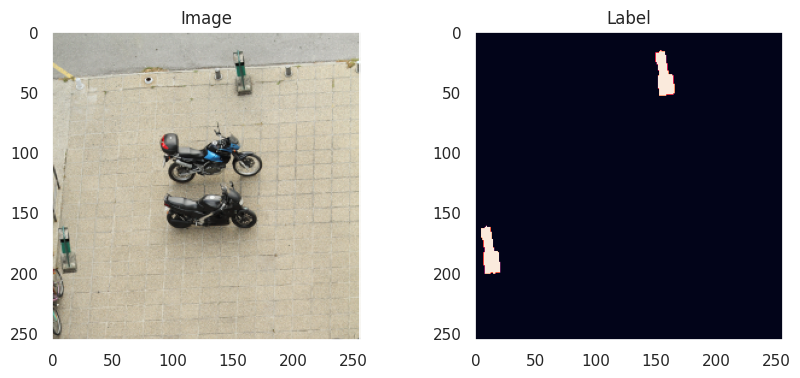

In [7]:
# Looking at samples from the dataset
for images, masks in dataset_test.skip(5).take(3):
    img_number = random.randint(0, images.shape[0] - 1)

    image = images[img_number].numpy()
    mask = masks[img_number].numpy()

    # Plotting
    _, axs = plt.subplots(1, 2, figsize=(10, 4))

    plots = {
        "Image": image,
        "Label": mask,
    }

    for ax, (name, plot) in zip(axs, plots.items()):
        ax.grid(False)
        ax.set_title(name)
        ax.imshow(plot)

plt.show()

In [20]:
# Define a simple mapping function
def add_dim(images, masks):
    # Convert labels to one-hot encoding
    masks = tf.cast(masks, tf.uint8)
    y_cat = tf.one_hot(masks, depth=N_CLASSES)

    images = tf.expand_dims(images, axis=-1)

    return images, y_cat

# Apply the mapping function
dataset_train = dataset_train.map(add_dim)
dataset_val = dataset_val.map(add_dim)
dataset_test = dataset_test.map(add_dim)

In [21]:
print(dataset_test)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>


In [22]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3, 1)
Labels Batch shape: (8, 256, 256, 2)
Feature shape per sample: (256, 256, 3, 1)
Max Value in Feature: 1.0
Label shape per sample: (256, 256, 2)
Label unique values: [1. 0.]


In [23]:
for features, labels in dataset_test.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3, 1)
Labels Batch shape: (8, 256, 256, 2)
Feature shape per sample: (256, 256, 3, 1)
Max Value in Feature: 1.0
Label shape per sample: (256, 256, 2)
Label unique values: [1. 0.]


# Evaluation

The code provides a comprehensive evaluation and visualization framework for semantic segmentation model performance. It includes functions for comparing model predictions to ground truth, computing Intersection over Union (IoU) for the background, Mean IoU, and Accuracy metrics on different datasets, and plotting metrics between main and ablation models. The code also loads pre-trained models and applies them to the test dataset, generating bar plots comparing performance metrics.

In [35]:
def show_img_pred(model_used, dataset=dataset_test, num_imgs=3, batch_skip=3):
    # Take one batch from the dataset
    for X_batch, y_batch in dataset.skip(batch_skip).take(num_imgs):
        # Randomly select an image from the batch
        random.seed(SEED)
        img_number = random.randint(0, X_batch.shape[0] - 1)
        img = X_batch[img_number]
        ground_truth = y_batch[img_number]
        ground_truth = np.argmax(ground_truth, axis=-1)


        # Reshape the image as required by the model
        img_input = np.expand_dims(img, 0)

        # Make a prediction
        predicted_img = np.squeeze(model_used.predict(img_input), axis=0)
        predicted_img = np.argmax(predicted_img, axis=-1)

        # Plotting
        _, axs = plt.subplots(1, 3, figsize=(12, 8))

        plots = {
            "Image": np.squeeze(img, axis=-1),
            "Ground Truth": ground_truth,
            "Prediction": predicted_img
        }
        for ax, (name, plot) in zip(axs, plots.items()):
            ax.set_title(f'{name}')
            ax.grid(False)
            ax.imshow(plot, interpolation="nearest")
        plt.show()

    return ground_truth, predicted_img

In [52]:
def calculate_Mean_IoU(model_used, dataset=dataset_test, n_classes=N_CLASSES):
    Mean_IOU = MeanIoU(
        num_classes=n_classes,
        sparse_y_true= False,
        sparse_y_pred=False,
    )


    for X_test, y_test in dataset:
        y_pred = model_used.predict(X_test, verbose=False)
        Mean_IOU.update_state(y_test, y_pred)

    # Calculate the Mean IoU value
    return Mean_IOU.result().numpy()

def calculate_accuracy(model_used, dataset=dataset_test, n_classes=N_CLASSES):
    acc = CategoricalAccuracy()

    for X_test, y_test in dataset:
        y_pred = model_used.predict(X_test, verbose=False)
        acc.update_state(y_test, y_pred)

    # Calculate the Accuracy value
    return acc.result().numpy()


In [61]:
def plot_metric(metric_name, values, models, sets, ax):
    # Set up the bar positions
    bar_width = 0.35
    r1 = np.arange(len(sets))
    r2 = [x + bar_width for x in r1]

    # Plot the bars
    for i, model in enumerate(models):
        ax.bar(r1 if i % 2 == 0 else r2, values[i], width=bar_width, label=model)

    # Customize the plot
    ax.set_ylabel(f'{metric_name}')
    ax.set_title(f'Model vs Ablation {metric_name}')
    ax.set_xticks([r + bar_width / 2 for r in range(len(sets))], sets)
    ax.set_ylim(0, 1)
    ax.legend(models)

def compare_models(models: dict, metrics: dict, datasets:dict):
    results = {metric_k: {model_k: [] for model_k in models.keys()}
               for metric_k in metrics.keys()}

    iter_keys = product(metrics.keys(), models.keys(), datasets.keys())
    iter_values = product(metrics.values(), models.values(), datasets.values())

    for keys, values in zip(iter_keys, iter_values):
        metric_k, model_k,  dataset_k = keys[0], keys[1], keys[2]
        metric_v, model_v, dataset_v = values[0], values[1], values[2]

        results[metric_k][model_k].append(metric_v(model_v, dataset=dataset_v))
    return results

def plot_models_comparison(models: dict, metrics: dict, datasets:dict):
    results = compare_models(models, metrics, datasets)
    _, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

    for ax, metric_k in zip(axs, metrics.keys()):
        plot_metric(
            metric_k,
            list(results[metric_k].values()),
            models.keys(),
            datasets.keys(),
            ax=ax
        )

    plt.show()

In [14]:
# Load previously saved model
model = load_model("/content/drive/MyDrive/cv_data/saved_models/forg_model.tf", compile=False)

In [15]:
model_ablation = load_model("/content/drive/MyDrive/cv_data/saved_models/forg_model.tf", compile=False)

In [16]:
y_pred = model.predict(dataset_test)

7/7 [==============================] - 4s 140ms/step


In [17]:
y_pred.shape

(50, 256, 256, 2)

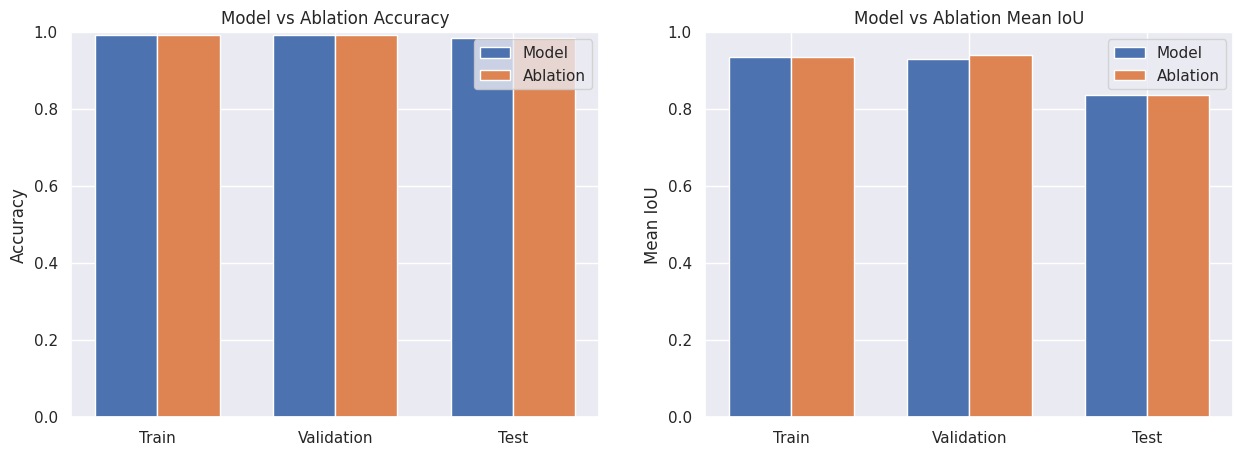

In [60]:
models = {'Model': model, 'Ablation': model_ablation}
metrics = {'Accuracy': calculate_accuracy, 'Mean IoU': calculate_Mean_IoU}
datasets = {'Train': dataset_train, 'Validation': dataset_val, 'Test': dataset_test}

plot_models_comparison(models, metrics, datasets)

# Image Prediction Comparison: Ground Truth vs. Model Predictions

The code compares ground truth and model predictions for image segmentation using the show_img_pred function. It extracts the ground truth and predicted images, displays unique values, and repeats for an alternative model (model_ablation). This analysis provides insights into segmentation results for both main and ablation models.

1/1 [==============================] - 0s 19ms/step


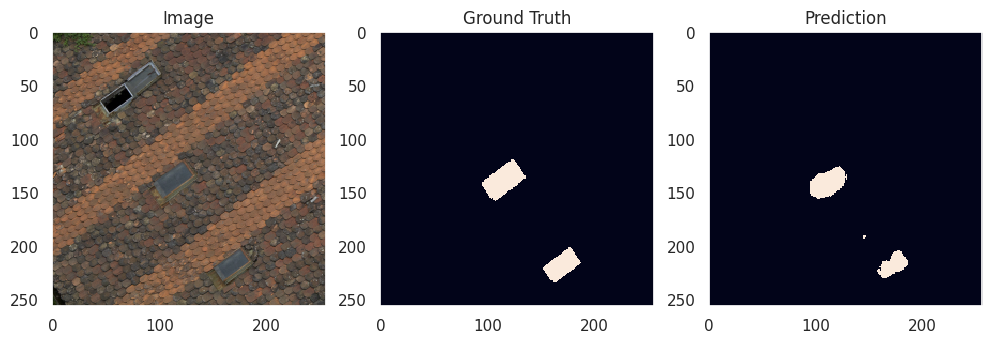

1/1 [==============================] - 0s 19ms/step


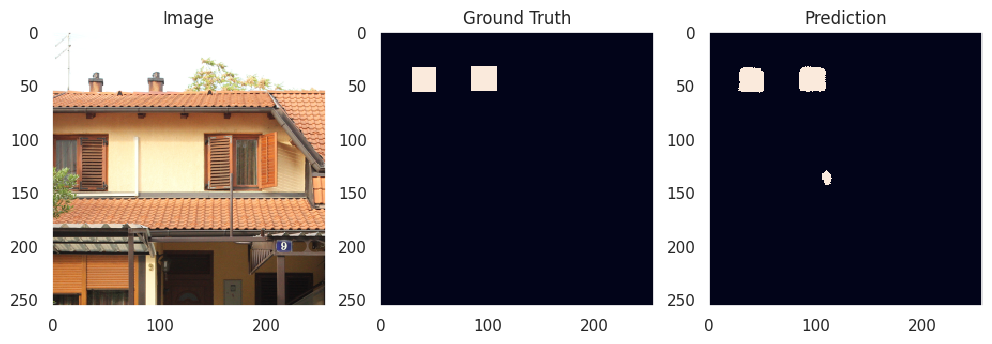

1/1 [==============================] - 0s 19ms/step


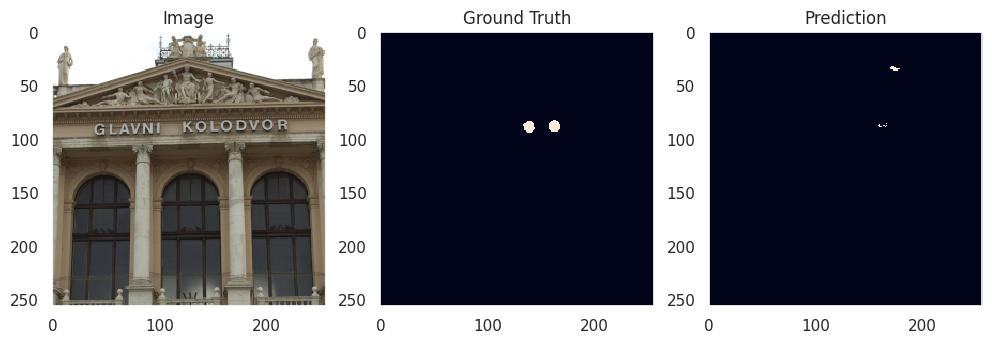

In [36]:
ground_truth, predicted_img = show_img_pred(model, dataset=dataset_test)

In [37]:
np.unique(ground_truth), np.unique(predicted_img)

(array([0, 1]), array([0, 1]))

1/1 [==============================] - 0s 19ms/step


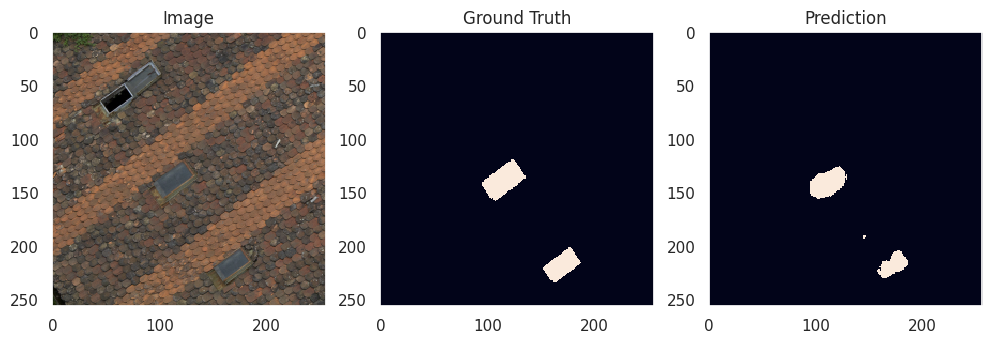

1/1 [==============================] - 0s 18ms/step


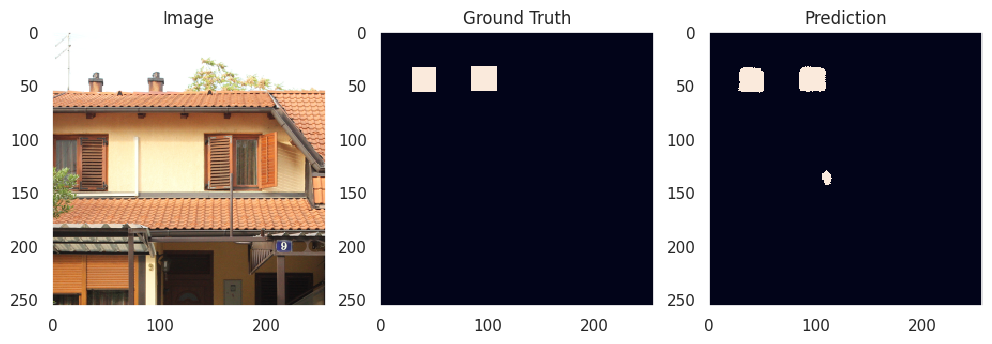

1/1 [==============================] - 0s 18ms/step


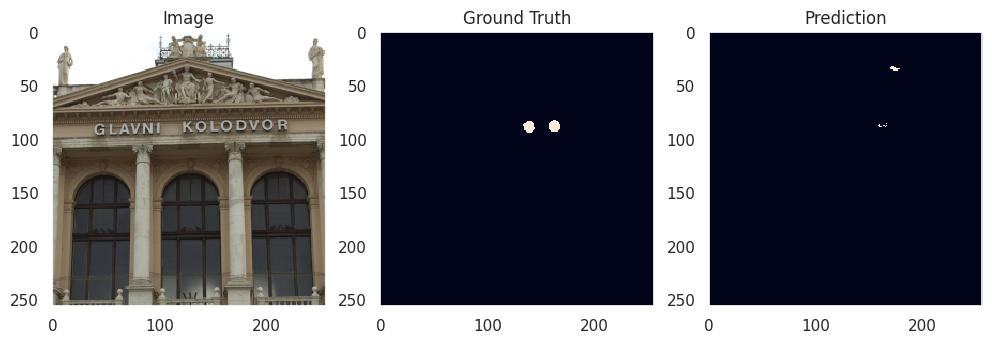

In [38]:
ground_truth, predicted_img_ablation = show_img_pred(model_ablation, dataset=dataset_test)

In [34]:
np.unique(ground_truth), np.unique(predicted_img_ablation)

(array([0, 1]), array([0, 1]))

As we can see from the results above, the ablation model's perfromance was the same as the original model.

As future work, concatenating the output of the PoolMax layers and the input to a decoder block could help increase the accuracy and prevent the loss of information.